### Utilities 
- ```downsample_merged_file()``` - creates a training data file from **MULTIPLE** indivdiual files
- ```downsample()``` 
    - Useful for IEEE PHM data 
    - Downsample the file to target-rows (e.g. 400)
    - Modifies toolwear to be micro-mm i.e. x 1000
    - Modifies toolwear > 300 um
    - Modifies ACTION_CODE to 1 if tool-wear > 300

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

WEAR_THRESHOLD = 300
TARGET_ROWS = 400

# Define the list of CSV files
csv_files = ['PHM_C01', 'PHM_C04', 'PHM_C06']
add_tw = [150, 120, 100]

def downsample(df, target_rows):
    nrows = len(df.index)
    sample_rate = int(nrows/TARGET_ROWS)
    df_downsampled = df.iloc[::sample_rate, :]
    print(f'- Down-sampling. Input data records: {len(df.index)}. Sampling rate: {sample_rate}. Expected rows {round(len(df.index)/sample_rate)}. Down-sampled to {len(df_downsampled.index)} rows.')
    return(df_downsampled)

- Down-sampling. Input data records: 34722. Sampling rate: 86. Expected rows 404. Down-sampled to 404 rows.
- Down-sampling. Input data records: 35279. Sampling rate: 88. Expected rows 401. Down-sampled to 401 rows.
- Down-sampling. Input data records: 34674. Sampling rate: 86. Expected rows 403. Down-sampled to 404 rows.


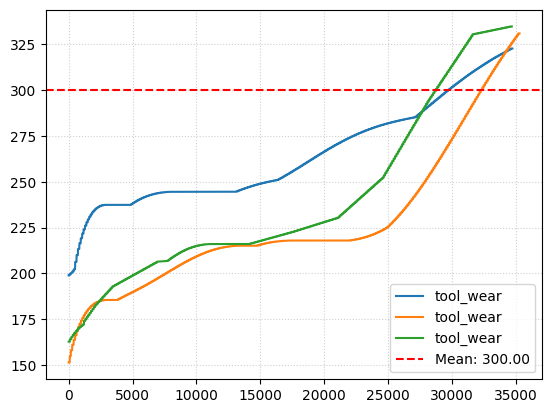

In [5]:
# Iterate through the list
n=0
for file_name in csv_files:
    file = f'{file_name}.csv'
    df = pd.read_csv(file)
    df['ACTION_CODE'] = 0
    df['tool_wear'] *= 1e3
    df['tool_wear'] += add_tw[n]
    df.loc[df['tool_wear'] >= WEAR_THRESHOLD, 'ACTION_CODE'] = 1
    ax = df['tool_wear'].plot()
    r = len(df.index)
    N = int(r/TARGET_ROWS)
    ds_df = downsample(df, N)
    ds_df.to_csv(f'{file_name}_DS.csv', index=False)
    n += 1

WEAR_THRESHOLD  = 300
ax.axhline(y=WT, color='r', linestyle='--', label=f'Mean: {WEAR_THRESHOLD:.2f}')
ax.grid(True, linestyle=':', alpha=0.6)
ax.legend()
plt.show()

In [6]:
def downsample_merged_file(data_file: str, records_per_procedure: int = 30, save_path: str = None) -> pd.DataFrame:
    """
    Downsample a merged CSV file preserving order, keeping 'records_per_procedure' for each 'PROC'.
    
    Args:
        data_file (str): Path to the input CSV file.
        records_per_procedure (int): Number of records to keep for each procedure (default 30).
        save_path (str, optional): Path to save the downsampled CSV.
        
    Returns:
        pd.DataFrame: Downsampled DataFrame.
    """
    try:
        df = pd.read_csv(data_file)
    except FileNotFoundError:
        print(f"Error: File not found: {data_file}")
        return pd.DataFrame()
        
    if 'PROC' not in df.columns:
        print("Error: Input file must contain 'PROC' column.")
        return df
    
    # Get unique procedures while preserving order of appearance
    procedures = df['PROC'].unique()
    
    downsampled_dfs = []
    print(f"Downsampling {data_file}...")
    
    for proc in procedures:
        proc_df = df[df['PROC'] == proc]
        # Keep first N records
        subset = proc_df.iloc[:records_per_procedure]
        downsampled_dfs.append(subset)
        print(f"  Processed {proc}: kept {len(subset)}/{len(proc_df)} rows")
    
    if not downsampled_dfs:
        return pd.DataFrame()
        
    result_df = pd.concat(downsampled_dfs)
    
    print(f"Total rows: {len(result_df)}")
    
    if save_path:
        try:
            result_df.to_csv(save_path, index=False)
            print(f"Saved downsampled data to: {save_path}")
        except Exception as e:
            print(f"Error saving file: {e}")
            
    return result_df
